<a href="https://colab.research.google.com/github/amandaay/BigDataAnalytics/blob/main/BigDataAnalyticsPart2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset from kaggle

## feel free to skip this step
### By obtaining csv file from https://storage.googleapis.com/cs7280-proj3/redfin.csv instead. This saves time from downloading the data again.

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Step 4: Set appropriate permissions for the Kaggle API token
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Step 5: Download the dataset
!kaggle datasets download -d vincentvaseghi/us-cities-housing-market-data

 99% 0.99G/1.01G [00:26<00:00, 57.0MB/s]
100% 1.01G/1.01G [00:26<00:00, 40.4MB/s]


In [ ]:
# Step 6: Unzip the dataset
!unzip us-cities-housing-market-data.zip

Archive:  us-cities-housing-market-data.zip
  inflating: city_market_tracker.tsv000  


## Convert tsv file to csv file format

In [ ]:
# Step 7: Import necessary libraries
import pandas as pd

In [ ]:
csv_table = pd.read_table('city_market_tracker.tsv000', sep='\t')

In [ ]:
csv_table.to_csv('redfin.csv', index=False)

KeyboardInterrupt: 

In [ ]:
import os
print(os.getcwd())

In [ ]:
!mv redfin.csv /content/drive/MyDrive

# Install Pyspark and appropriate files

In [ ]:
#@title Install all the appropriate packages

!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

In [ ]:
#@title Import and create Spark Context

# Let's import the libraries we will need
import itertools

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
from pyspark import SparkFiles

In [48]:
from pyspark.sql.functions import year, col

In [ ]:
# URL of the CSV file
url = "https://storage.googleapis.com/cs7280-proj3/redfin.csv"

In [ ]:
sc.addFile(url)

In [ ]:
path = SparkFiles.get("redfin.csv")

In [ ]:
df = spark.read.csv("file://"+ path, header=True, inferSchema=True)

In [ ]:
df.show()

In [146]:
distinct_states_df = df.select(col("state"), col("state_code")).distinct()

In [ ]:
distinct_states_df.show(distinct_states_df.count(), truncate=False)

In [57]:
sold_inventory = df.select(year("period_begin").alias("year"), "homes_sold", "inventory", "state")

In [58]:
sold_inventory = sold_inventory.withColumn("difference", col("inventory") - col("homes_sold"))

In [59]:
sold_inventory = sold_inventory.na.drop(subset=["difference"])

In [ ]:
sold_inventory.show()

In [61]:
sold_inventory = sold_inventory.rdd

In [ ]:
sold_inventory.take(5)

In [65]:
# sort by year and sort by differences
sorted_sold_inventory = sold_inventory.sortBy(lambda x: (x[0], -x[4]))

In [ ]:
sorted_sold_inventory.take(5)

In [102]:
grouped_by_year_state = sorted_sold_inventory.map(lambda x: ((x[0], x[3]), (x[4], 1))).reduceByKey(lambda x, y: (x[0]+y[0], x[1] + y[1])).mapValues(lambda x: (x[0] / x[1])).map(lambda x:( x[0][0], x[0][1],x[1]))

In [ ]:
grouped_by_year_state.take(10)

In [157]:
# Take the top 5 differences for each year
top_5_by_year = grouped_by_year_state.groupBy(lambda x: x[0]).flatMapValues(lambda x: sorted(x, key=lambda y: -y[2])[:5]).map(lambda x: (x[0], x[1][1], x[1][2]))

In [ ]:
top_5_by_year.collect()

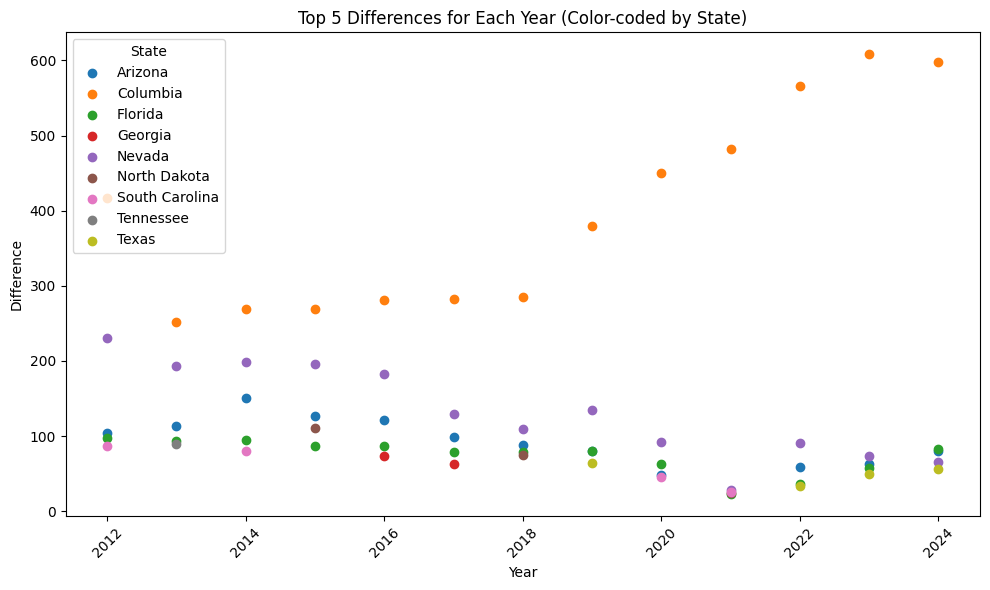

In [164]:
import matplotlib.pyplot as plt

# Collect the data from the RDD
data = top_5_by_year.collect()

# Prepare data for plotting
years = [row[0] for row in data]
states = [row[1] for row in data]
differences = [row[2] for row in data]

# Plotting
plt.figure(figsize=(10, 6))

# Create a color map for states
cmap = plt.get_cmap('tab10')

# Iterate over each unique state and plot its differences for each year
for i, state in enumerate(sorted(set(states))):
    state_data = [data[j] for j in range(len(data)) if data[j][1] == state]
    years = [row[0] for row in state_data]
    differences = [row[2] for row in state_data]
    plt.scatter(years, differences, label=state, color=cmap(i))

plt.title('Top 5 Differences for Each Year (Color-coded by State)')
plt.xlabel('Year')
plt.ylabel('Difference')
plt.xticks(rotation=45)
plt.legend(title='State', loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
spark.stop()